In [39]:
import os
import glob
import PIL
import cv2
import random
from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow
import tensorflow as tf
from tensorflow.keras import layers
import keras 
from keras.utils.np_utils import normalize
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import preprocess_input
from IPython.display import display
from PIL import Image

%matplotlib inline

In [ ]:
# Downlaod dataSet From 

# https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view

In [40]:
# Inilization of size, classes, curr directory

img_shape = 128
n_classes=4
directory_path = os.getcwd()

In [41]:
# Creating the Function that can convert Img to image matrix and return it 

def extract_tif_photo(directory):
    img = Image.open(directory)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

In [42]:
# making the image and Mask of the Image and getting the Mask Values

tif_file_path = glob.glob(directory_path + r"\sandstone_dataset\full_labels_for_deep_learning\128_patches\*.tif")

train_images = extract_tif_photo(tif_file_path[0])
train_masks = extract_tif_photo(tif_file_path[1])
print(f'Image shape : {train_images.shape}')
print(f'mask shape : {train_masks.shape}')
print(f'Unique Mask Value : {np.unique(train_masks)}')

Image shape : (1600, 128, 128)
mask shape : (1600, 128, 128)
Unique Mask Value : [1 2 3 4]


In [43]:
# out mask contain values 1,2,3,4 but we need 0,1,2,3,4
        
    '''
        This Step is Not Necessary 
    '''

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(f'unique mask value from changed to {np.unique(train_masks_encoded_original_shape)}')

C:\Users\ADMIN\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


unique mask value from changed to [0 1 2 3]


In [44]:
# Expanding the Dimension of images to 3D and Normalizing it

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

Class values in the dataset are ...  [0 1 2 3]


In [ ]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training

from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(len(X1))
print(len(X_test))
print(len(y1))
print(len(y_test))

In [ ]:
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print(len(X_train))
print(len(X_do_not_use))
print(len(y_train))
print(len(y_do_not_use))
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

In [ ]:
# converting the Mask image value into categorical

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
# Making our Model it is U-Net Architecture

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Inilizating the class weights 

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                                     class_weight = 'balanced',
                                                     classes = np.unique(train_masks_reshaped_encoded),
                                                     y = train_masks_reshaped_encoded
                                                )
print("Class weights are...:", class_weights)

In [ ]:
# Getting out Images Shape to load it into out Model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
# Inilization of the Model with Compile 

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [32]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

# Starting the Training 

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')

Class weights are...: [1.93354786 3.07345989 0.32786918 9.30640739]
Epoch 1/50
72/72 [==============================] - 15s 97ms/step - loss: 0.7259 - accuracy: 0.7397 - val_loss: 0.5245 - val_accuracy: 0.8657
Epoch 2/50
72/72 [==============================] - 5s 63ms/step - loss: 0.4352 - accuracy: 0.8739 - val_loss: 0.4273 - val_accuracy: 0.8697
Epoch 3/50
72/72 [==============================] - 5s 64ms/step - loss: 0.3635 - accuracy: 0.8774 - val_loss: 0.3686 - val_accuracy: 0.8721
Epoch 4/50
72/72 [==============================] - 5s 64ms/step - loss: 0.3120 - accuracy: 0.8860 - val_loss: 0.3317 - val_accuracy: 0.8847
Epoch 5/50
72/72 [==============================] - 5s 64ms/step - loss: 0.2740 - accuracy: 0.9015 - val_loss: 0.2778 - val_accuracy: 0.9035
Epoch 6/50
72/72 [==============================] - 5s 64ms/step - loss: 0.2377 - accuracy: 0.9155 - val_loss: 0.2328 - val_accuracy: 0.9127
Epoch 7/50
72/72 [==============================] - 5s 64ms/step - loss: 0.2300 - acc

In [ ]:
# Getting the Accuracy of Out Model

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

5/5 [==============================] - 0s 41ms/step - loss: 0.1350 - accuracy: 0.9583
Accuracy is =  95.83187103271484 %


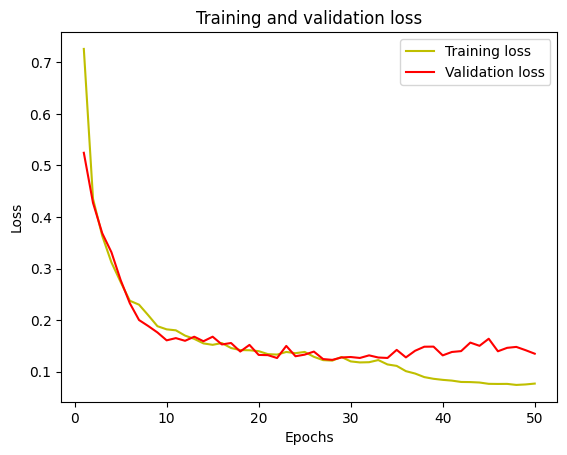

In [66]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Saving out model in directory for further use

model.save('models/sand_storm_model.hdf5')

In [45]:
# Loading out Model

model = keras.models.load_model('models/sand_storm_model.hdf5')

In [50]:
# Predicting the X_test

predicted_mask = model.predict(X_test)
predicted_mask.shape

(160, 128, 128, 4)

In [51]:
# Applying the Argmax in the predicted Mask and the Original mask

real_mask=np.argmax(y_test_cat, axis=3)
model_mask=np.argmax(predicted_mask, axis=3)

(160, 128, 128)

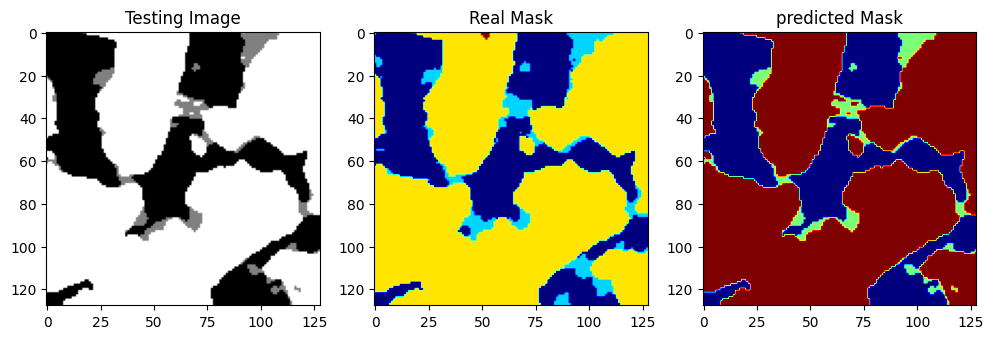

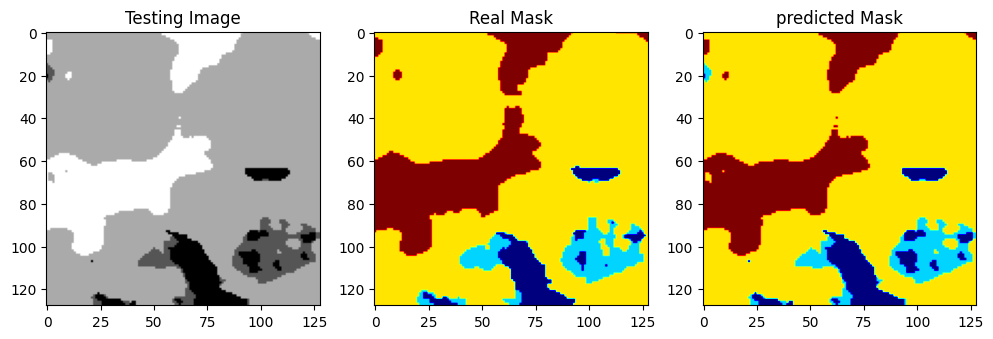

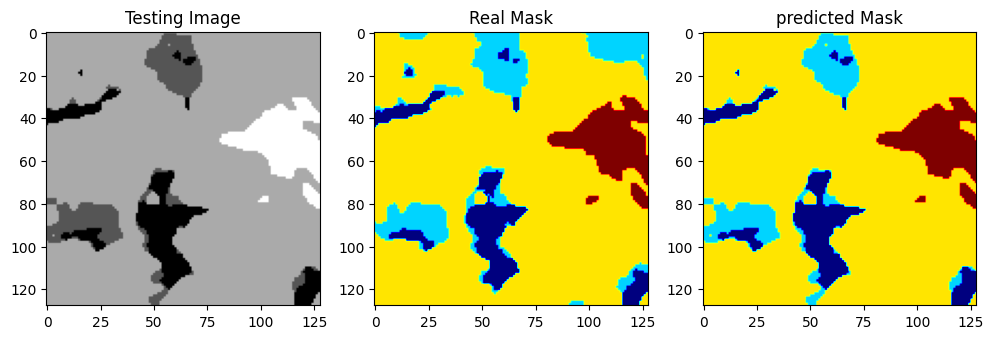

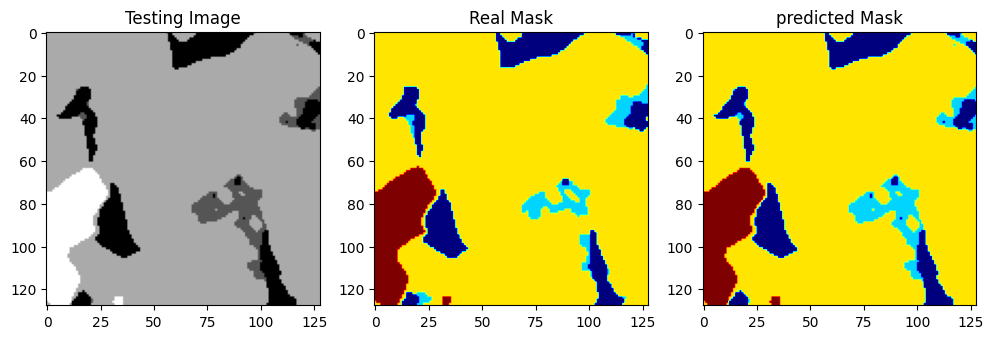

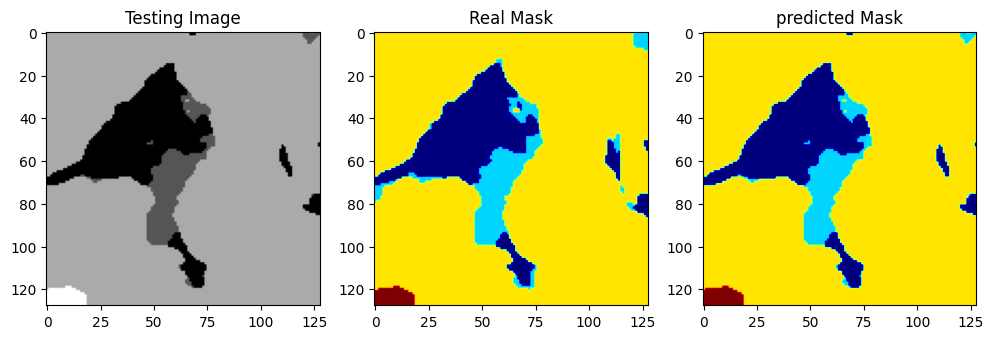

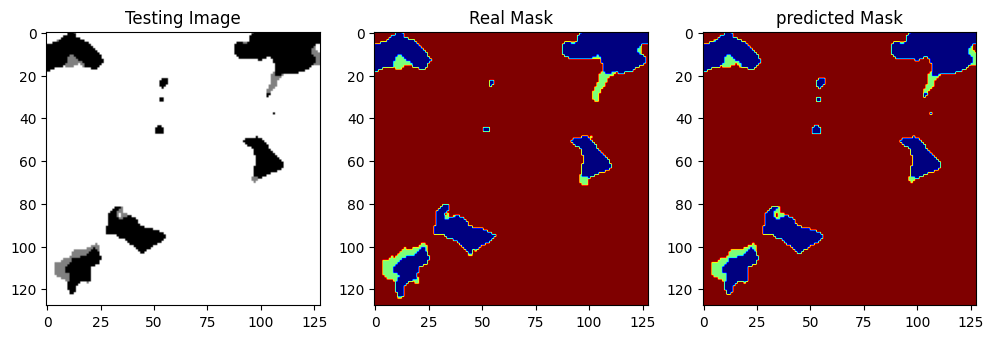

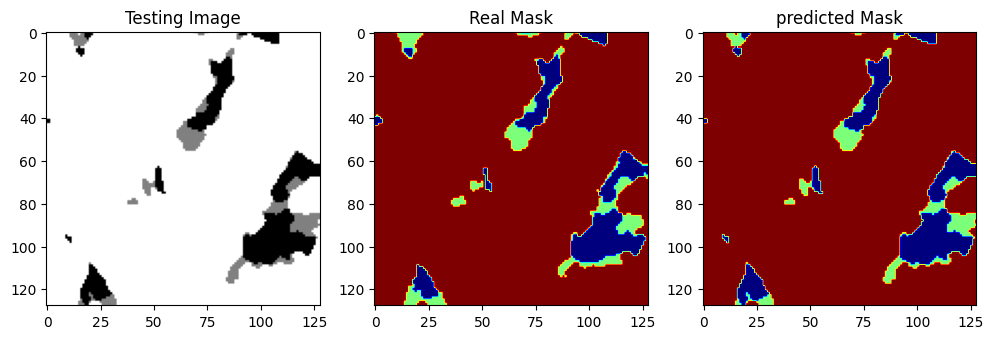

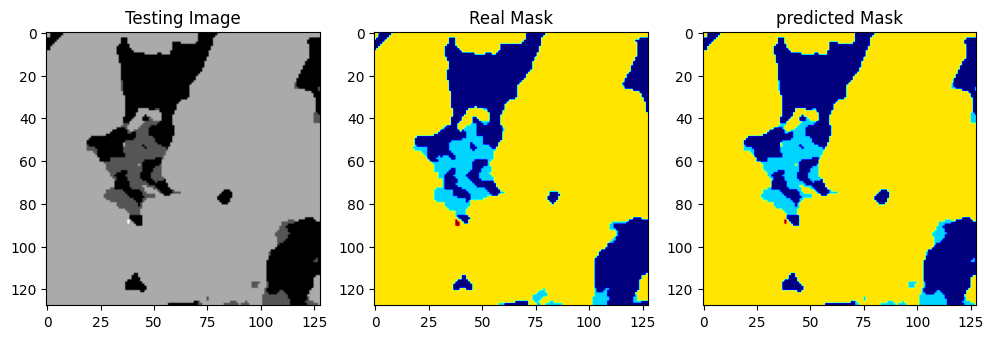

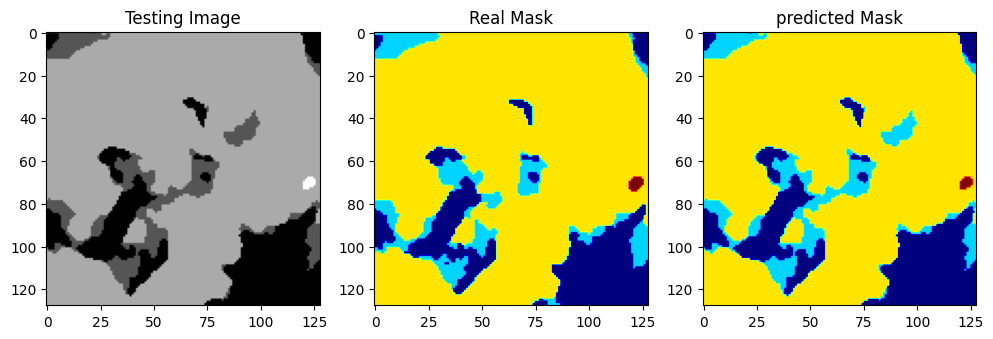

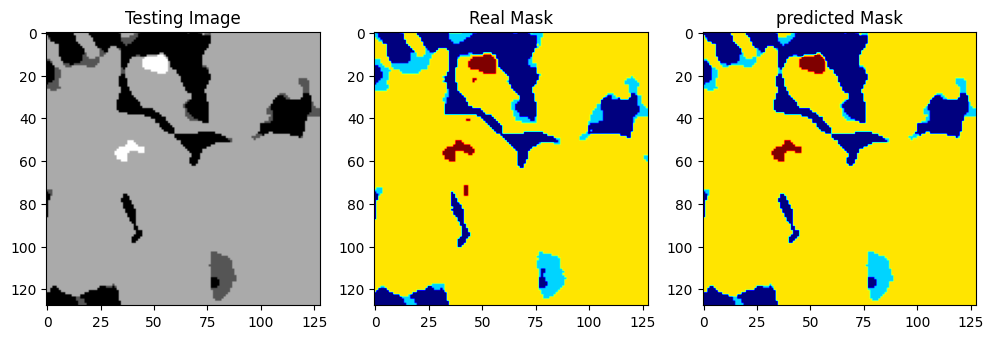

In [60]:
# Visulization of Our Model Output

for i in range(10):
    random = np.random.choice(np.arange(X_test.shape[0]))
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(model_mask[random], cmap='gray')
    plt.subplot(232)
    plt.title('Real Mask')
    plt.imshow(real_mask[random], cmap='jet')
    plt.subplot(233)
    plt.title('predicted Mask')
    plt.imshow(model_mask[random], cmap='jet')
    plt.show()